# Data management

In this notebook, we will build and train a model from the dataset. First, let's reproduce the data management we did in the previous notebook. 

In [1]:
options(digits = 2) # use two decimal places for all floating-point values

library(dplyr) # data management
library(ggplot2) # visualizations
library(nycflights13) # dataset

# add airplane and carrier data
flights_full = flights %>% 
  left_join(airlines, by = "carrier") %>% 
  left_join(planes %>% 
              select(tailnum, type, manufacturer, model, engine), 
            by = "tailnum") %>% 
  select(-carrier)

# remove all flights with no arrival delay
flights_full = flights_full %>% 
  filter(!is.na(flights_full$arr_delay))

# replace missing values in dataframe
flights_full[is.na(flights_full)] = "Unknown"

# convert hrs/mins into minutes
dep_mins = (flights_full$dep_time %% 100) + (flights_full$dep_time - (flights_full$dep_time %% 100)) * 0.6
sched_dep_mins = (flights_full$sched_dep_time %% 100) + (flights_full$sched_dep_time - (flights_full$sched_dep_time %% 100)) * 0.6
arr_mins = (flights_full$arr_time %% 100) + (flights_full$arr_time - (flights_full$arr_time %% 100)) * 0.6
sched_arr_mins = (flights_full$sched_arr_time %% 100) + (flights_full$sched_arr_time - (flights_full$sched_arr_time %% 100)) * 0.6

# convert month/day into day of year
days_per_month = c(0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365)
day_of_year = days_per_month[flights_full$month] + flights_full$day

# add new columns to dataframe
flights_full = flights_full %>% 
  mutate(dep_mins, 
         sched_dep_mins, 
         arr_mins, 
         sched_arr_mins, 
         day_of_year)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




From the EDA notebook, I am choosing the day of year, scheduled departure time, distance between airports, airline, origin, and departure delay as features for the model. 

In [2]:
# select relevant features
df = flights_full %>% 
  select(day_of_year, sched_dep_mins, distance, name, origin, dep_delay, arr_delay)

# One-hot encoding

Airline and origin are categorical, so we need to encode them. This is easy to do with the "caret" library, which we will also use for model fitting. 

In [3]:
# one-hot encoding for categorical variables
library(caret)
dummy = dummyVars(" ~ name + origin", data = df)
onehot = data.frame(predict(dummy, newdata = df))
df = df %>% 
  mutate(onehot) %>% 
  select(-name, -origin)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




This leaves us with 23 features after encoding the categorical variables. This seems like a lot, so let's try using principal component analysis to reduce the dimensionality of this dataset. We will obviously need to drop the arrival delay column first, in order to avoid data leakage. 

# Dimensionality Reduction (via PCA)

In [4]:
# PCA
pca = df %>% 
  select(-arr_delay) %>% 
  scale(center = TRUE, scale = TRUE) %>% 
  as.data.frame() %>% 
  svd()

Now, let's graph the relative amount of information in the new features to decide which ones to keep. 

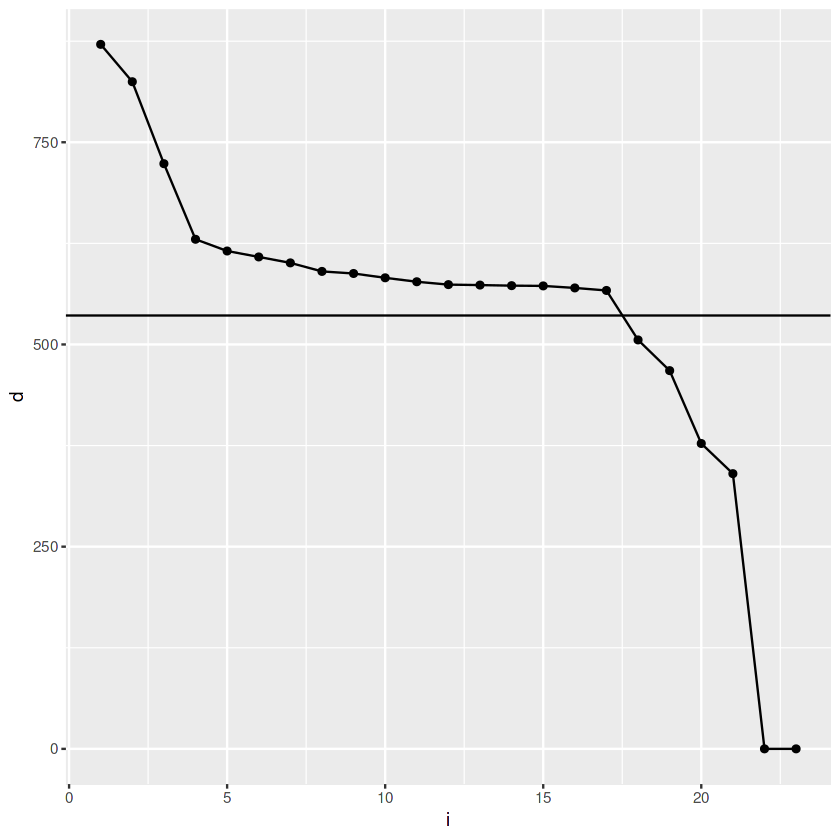

In [5]:
# decide which variables to keep
ggplot(data = data.frame(d = pca$d, i = 1:23), 
       mapping = aes(x = i, y = d)) + 
  geom_point() + 
  geom_line() + 
  geom_hline(yintercept = mean(pca$d))

The horizontal line is drawn through the average value of these data points. I originally tried fitting a model with the first 17 features (the ones above the horizontal line), but the accuracy was quite poor. In the end, I decided to drop only the last two features (corresponding to the zeros on the graph above). 

In [6]:
# remove V22 and V23
df_pca = as.data.frame(pca$u) %>% 
  select(-c(V22, V23)) %>% 
  mutate(arr_delay = df$arr_delay)

# Building a model

I will be using a linear regression model with 5-fold cross-validation. Because there are 21 features, I don't expect the accuracy to be very high. 

In [7]:
# linear regression
control = trainControl(method = "cv", number = 5)
lm = train(arr_delay ~ ., 
              data = df_pca, 
              method = "lm", 
              metric = "Rsquared", 
           trControl = control)
print(lm)

Linear Regression 

327346 samples
    21 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 261877, 261876, 261878, 261876, 261877 
Resampling results:

  RMSE  Rsquared  MAE
  18    0.84      13 

Tuning parameter 'intercept' was held constant at a value of TRUE


This linear regression model has an R-squared value of 0.84 and a mean absolute error of 13. Both of these values are much better than I expected. 

Because of poor time management, I was unable to experiment with other machine learning algorithms. I failed to take into account the large size of this dataset, which means that more complex models with a greater number of parameters can take a very long time to train. 